# Stat451: Machine Learning -- L02: kNN in Python

STAT 451: Intro to Machine Learning (Fall 2021)  

- Instructor: Sebastian Raschka (sraschka@wisc.edu)   
- Course website: http://pages.stat.wisc.edu/~sraschka/

In [ ]:
# to install watermark (optional)
# uncomment the next line of code (and leave the "!")
#!pip install watermark

In [ ]:
# If you are using conda, you can also install watermark like this:
#!conda install watermark -y --channel conda-forge

In [1]:
%load_ext watermark
%watermark  -d -u -a 'Sebastian Raschka' -v -p numpy,scipy,matplotlib,sklearn

Author: Sebastian Raschka

Last updated: 2021-09-13

Python implementation: CPython
Python version       : 3.9.6
IPython version      : 7.27.0

numpy     : 1.21.2
scipy     : 1.7.0
matplotlib: 3.4.3
sklearn   : 0.24.2



## 0 - General Imports

I always find it helpful to put all the imports being used in the notebook into one cell somewhere at the top. This way, it is easy to tell what will be required for running the code in this notebook.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 1 - Load Dataset into a Pandas DataFrame

The next cell is actually not Python code but Bash terminal command that will show the first 10 lines of the [./iris.csv](./iris.csv) file. In Jupyter Notebook or Jupyer Lab you can run terminal commands by prepending "!" to a given line that is to be executed.

In [3]:
!head iris.csv 

Id,SepalLength[cm],SepalWidth[cm],PetalLength[cm],PetalWidth[cm],Species
1,5.1,3.5,1.4,0.2,Iris-setosa
2,4.9,3.0,1.4,0.2,Iris-setosa
3,4.7,3.2,1.3,0.2,Iris-setosa
4,4.6,3.1,1.5,0.2,Iris-setosa
5,5.0,3.6,1.4,0.2,Iris-setosa
6,5.4,3.9,1.7,0.4,Iris-setosa
7,4.6,3.4,1.4,0.3,Iris-setosa
8,5.0,3.4,1.5,0.2,Iris-setosa
9,4.4,2.9,1.4,0.2,Iris-setosa


The next line of code will read the CSV file into a Pandas `DataFrame` object so that we have it in our current Python session and can work with it:

In [4]:
df_iris = pd.read_csv('iris.csv')
df_iris.tail()

,Id,SepalLength[cm],SepalWidth[cm],PetalLength[cm],PetalWidth[cm],Species
145,146,6.7,3.0,5.2,2.3,Iris-virginica
146,147,6.3,2.5,5.0,1.9,Iris-virginica
147,148,6.5,3.0,5.2,2.0,Iris-virginica
148,149,6.2,3.4,5.4,2.3,Iris-virginica
149,150,5.9,3.0,5.1,1.8,Iris-virginica


## 2 - Get Features into a NumPy Array

Recently, machine learning libraries such as scikit-learn started to support Pandas DataFrames. However, traditionally, it is customary to work with NumPy arrays. In fact, `DataFrame`s are build on top of NumPy arrays, so NumPy arrays are a bit lower-level. Btw. you can think of a NumPy array as a tensor, you can have scalars, vectors, matrices, etc. represented as NumPy arrays.

In the next code cell, we are accessing the NumPy array that is embedded in the DataFrame via the `.values` attribute. More specifically, we are assigning only the 2 feature columns `'PetalLength[cm]', 'PetalWidth[cm]'` to a variable `X`. Here, `X` references the NumPy array of shape 150x2 (you can think of it as a matrix).

In [5]:
X = df_iris[['PetalLength[cm]', 'PetalWidth[cm]']].values
print(X.shape)

(150, 2)


The next cell will show the first 5 entries (examples) in the dataset:

In [6]:
X[:5, :]

array([[1.4, 0.2],
       [1.4, 0.2],
       [1.3, 0.2],
       [1.5, 0.2],
       [1.4, 0.2]])

## 3 - Get Class Labels into a NumPy Array

Similary to assigning the features to a new variable `X`, we are now assigning the class lables to a new variable, which we will call `y`. However, before we do that, let us map the class labels from a `string` representation into an `int` (integer) format. For this, we add a new column `ClassLabel` to the data frame:

In [7]:
label_dict = {'Iris-setosa': 0,
              'Iris-versicolor': 1,
              'Iris-virginica': 2}

df_iris['ClassLabel'] = df_iris['Species'].map(label_dict)
df_iris.tail()

,Id,SepalLength[cm],SepalWidth[cm],PetalLength[cm],PetalWidth[cm],Species,ClassLabel
145,146,6.7,3.0,5.2,2.3,Iris-virginica,2
146,147,6.3,2.5,5.0,1.9,Iris-virginica,2
147,148,6.5,3.0,5.2,2.0,Iris-virginica,2
148,149,6.2,3.4,5.4,2.3,Iris-virginica,2
149,150,5.9,3.0,5.1,1.8,Iris-virginica,2


Then, similar to before, we reference the underlying NumPy array via the `.values` attribute and assign it to a variable `y`:

In [8]:
y = df_iris['ClassLabel'].values
y[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

The next task is to divide the dataset into a training and a test set. Notice though that the first 10 entries are all zeros. This is because the dataset has not been shuffled yet. Hence, in Iris, the vector `y` will consists of 50 0's, 50 1's, and 50 2's (in that order).

It would thus be a bit problematic if we assigned the first 100 entries to a training set and the 50 last entries to the test set. Can you see why?



## 4 - Shuffle Dataset and Create Training and Test Subsets

In order to divide the dataset into a training and a test set, we are going to shuffle the dataset first. For illustration purposes, we will do this in multiple steps.

In the first step, we create an index array of our dataset: 

In [9]:
indices = np.arange(y.shape[0])
indices

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149])

Next, we shuffle this index array. Note that we use a random seed such that other people can reproduce the results. This means that if someone else uses this code on a different computer, the person will get the exact same shuffle order.

In [10]:
rnd = np.random.RandomState(123)
shuffled_indices = rnd.permutation(indices)
shuffled_indices

array([ 72, 112, 132,  88,  37, 138,  87,  42,   8,  90, 141,  33,  59,
       116, 135, 104,  36,  13,  63,  45,  28, 133,  24, 127,  46,  20,
        31, 121, 117,   4, 130, 119,  29,   0,  62,  93, 131,   5,  16,
        82,  60,  35, 143, 145, 142, 114, 136,  53,  19,  38, 110,  23,
         9,  86,  91,  89,  79, 101,  65, 115,  41, 124,  95,  21,  11,
       103,  74, 122, 118,  44,  51,  81, 149,  12, 129,  56,  50,  25,
       128, 146,  43,   1,  71,  54, 100,  14,   6,  80,  26,  70, 139,
        30, 108,  15,  18,  77,  22,  10,  58, 107,  75,  64,  69,   3,
        40,  76, 134,  34,  27,  94,  85,  97, 102,  52,  92,  99, 105,
         7,  48,  61, 120, 137, 125, 147,  39,  84,   2,  67,  55,  49,
        68, 140,  78, 144, 111,  32,  73,  47, 148, 113,  96,  57, 123,
       106,  83,  17,  98,  66, 126, 109])

Now that we have the shuffled indices, we can use them to shuffle both the features `X` and `y` relative to each other -- we do this to preserve the correspondence between feature and label in `X` and `y`:

In [11]:
X_shuffled, y_shuffled = X[shuffled_indices], y[shuffled_indices]

Finally, we can divide the dataset into training and test subsets:

In [12]:
X_train, y_train = X_shuffled[:105], y_shuffled[:105]
X_test, y_test = X_shuffled[105:], y_shuffled[105:]

## 5 - Doing Steps 1-4 in Scikit-Learn

Note that we went through a lot of steps in order to load the dataset and to split it into training and test subsets. We did this so that you develop an intuition for the procedure. However, there are also convenient functions in scikit-learn that allow us to do the exact same things in much fewer lines of code. I.e., the following code will load the iris dataset and split it into 30% test data and 70% training data:

In [13]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split


iris = load_iris()
X, y = iris.data[:, 2:], iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3,
                                                    random_state=123,
                                                    shuffle=True)

In [14]:
print(f'X_train.shape: {X_train.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_test.shape: {y_test.shape}')

X_train.shape: (105, 2)
y_train.shape: (105,)
X_test.shape: (45, 2)
y_test.shape: (45,)


## 6 - Plot Dataset

As you have probably already learned in other statistics classes, it is always a good idea to visualize your data before doing any further analyses. 

Below we are plotting all 4 features using a scatter plot matrix:

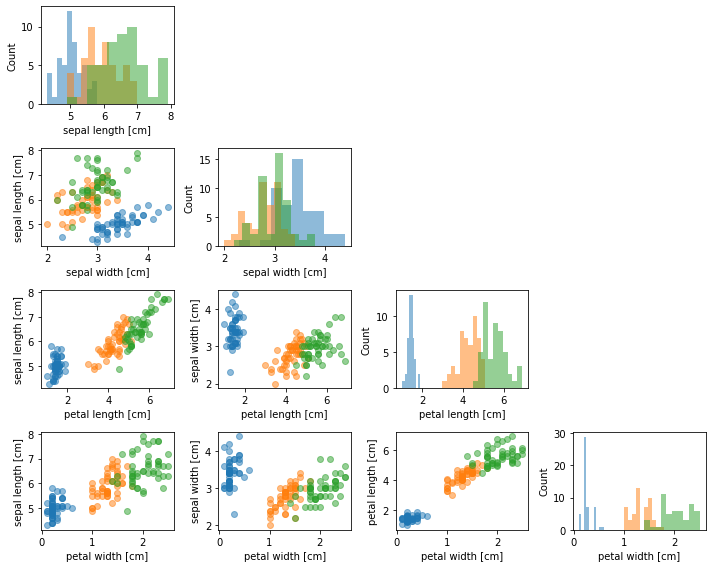

In [15]:
from mlxtend.plotting import scatterplotmatrix


names = ['sepal length [cm]', 'sepal width [cm]',
         'petal length [cm]', 'petal width [cm]']

fig, axes = scatterplotmatrix(iris.data[y==0], figsize=(10, 8), alpha=0.5)
fig, axes = scatterplotmatrix(iris.data[y==1], fig_axes=(fig, axes), alpha=0.5)
fig, axes = scatterplotmatrix(iris.data[y==2], fig_axes=(fig, axes), alpha=0.5, names=names)

plt.tight_layout()
plt.show()

However, we are only working with 2 features, i.e., petal length and petal width (via `X, y = iris.data[:, 2:], iris.target` earlier). Below is a scatter plot matrix of these 2 features for `X_train`:

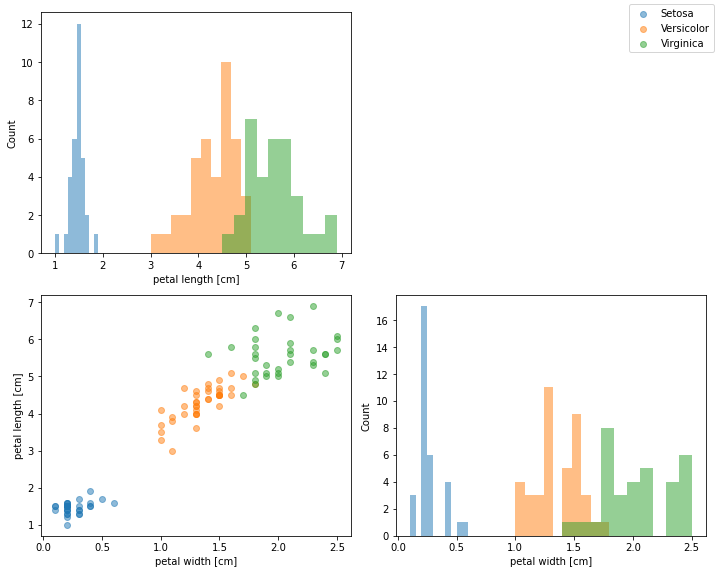

In [16]:
names = ['petal length [cm]', 'petal width [cm]']

fig, axes = scatterplotmatrix(X_train[y_train==0], figsize=(10, 8), alpha=0.5, label="Setosa")
fig, axes = scatterplotmatrix(X_train[y_train==1], fig_axes=(fig, axes), alpha=0.5, label="Versicolor")
fig, axes = scatterplotmatrix(X_train[y_train==2], fig_axes=(fig, axes), alpha=0.5, names=names, label="Virginica")

fig.legend()

plt.tight_layout()
plt.show()

In this case, it may be overkill to use the scatterplot function; we can create a scatter plot using matplotlib directly:

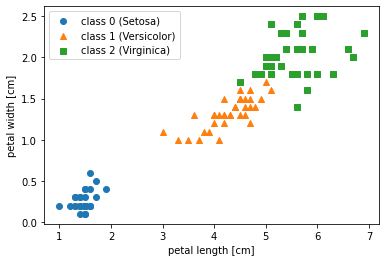

In [17]:
plt.scatter(X_train[y_train == 0, 0],
            X_train[y_train == 0, 1],
            marker='o',
            label='class 0 (Setosa)')

plt.scatter(X_train[y_train == 1, 0],
            X_train[y_train == 1, 1],
            marker='^',
            label='class 1 (Versicolor)')

plt.scatter(X_train[y_train == 2, 0],
            X_train[y_train == 2, 1],
            marker='s',
            label='class 2 (Virginica)')

plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')

plt.show()

Q: What can you learn about this dataset? Pay close attention to the two axes ...

## 7 - Fit k-Nearest Neighbor Model

Next, we are going to use the `KNeighborsClassifier` class from scikit-learn and instantiate a new KNN object, which we call `knn_model`. Then, we "fit" this model the training dataset:

In [18]:
from sklearn.neighbors import KNeighborsClassifier


knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

Q: What distance measure is used by default?

## 8 - Use kNN Model to Make Predictions

After "fitting" the KNN model, we can now make predictions on new data points that the model has not seen before. The test set represents such data points. Of course, we have labels for the test set as well, but we only use these labels to evaluate the model -- i.e., we compare the predictions to the true labels in the test set in order to find out how good the model is:

In [19]:
y_pred = knn_model.predict(X_test)

In [20]:
num_correct_predictions = (y_pred == y_test).sum()
accuracy = (num_correct_predictions / y_test.shape[0]) * 100

# print('Test set accuracy: %.2f%%' % accuracy)

print(f'Test set accuracy: {accuracy:.2f}%')

Test set accuracy: 95.56%


In [21]:
# print('Test set accuracy: %.2f%%' % (knn_model.score(X_test, y_test)*100))

print(f'Test set accuracy: {knn_model.score(X_test, y_test)*100:.2f}%')

Test set accuracy: 95.56%


## 9 - Visualize Decision Boundary

Usually, in machine learning, we work with datasets that have more then 2 feature variables. For educational purposes, however, we chose a very simple dataset consisting of only two features here (the petal length and the petal width of Iris flowers). If we have only two features, we can easily visualize the decision boundary of the model -- here, we will be using a convenience function I implemented in the MLxtend library:

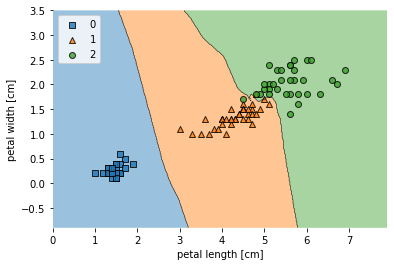

In [22]:
from mlxtend.plotting import plot_decision_regions


plot_decision_regions(X_train, y_train, knn_model)
plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.show()

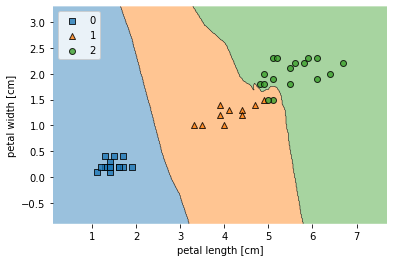

In [23]:
plot_decision_regions(X_test, y_test, knn_model)
plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.show()